# Approximately Bayes Update (ABU)

In [1]:
import numpy as np
import pandas as pd
from stabletrees import AbuTree,BABUTree,BaseLineTree, BABUTreeI, STTree
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_poisson_deviance
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
EPSILON = 0.000001
%matplotlib inline


In [2]:
def S1(pred1, pred2):
    return np.std(np.log((pred2+EPSILON)/(pred1+EPSILON)))#np.mean((pred1- pred2)**2)#

def S2(pred1, pred2):
    return np.mean((pred1- pred2)**2)

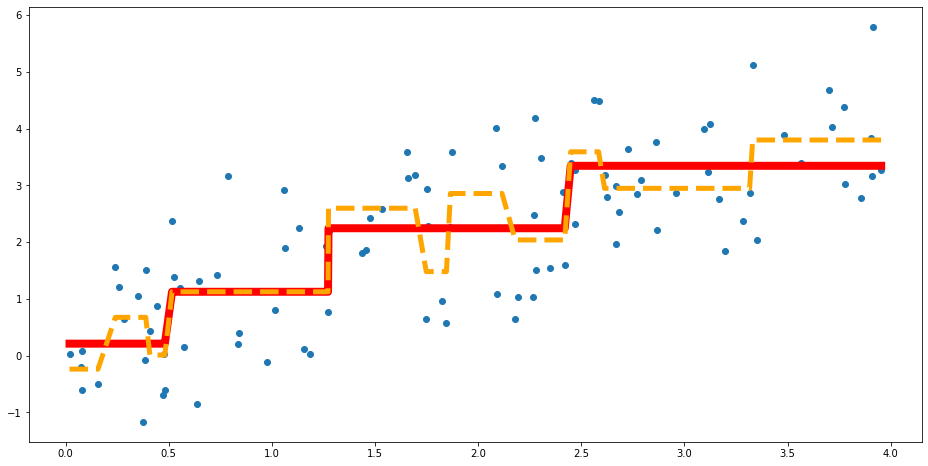

In [3]:
np.random.seed(0)
n = 100
plt.rcParams["figure.figsize"] = (16,8)
X = np.random.uniform(size=(n,1),low=0,high=4)
y = np.random.normal(loc=X.ravel(),scale=1,size = n)
parameters = {'max_depth':[None, 5, 10],"min_samples_leaf": [1,5], "ccp_alpha" : [0,0.01]} # , 
clf = GridSearchCV(DecisionTreeRegressor(random_state=0), parameters).fit(X,y)
t = BaseLineTree(adaptive_complexity=True).fit(X,y)
params = clf.best_params_
plt.scatter(X,y)
plt.plot(np.sort(X,axis=0), t.predict(np.sort(X,axis=0)),c = "r", linewidth=8)
plt.plot(np.sort(X,axis=0), clf.predict(np.sort(X,axis=0)),c = "orange",linewidth=5,linestyle='dashed')

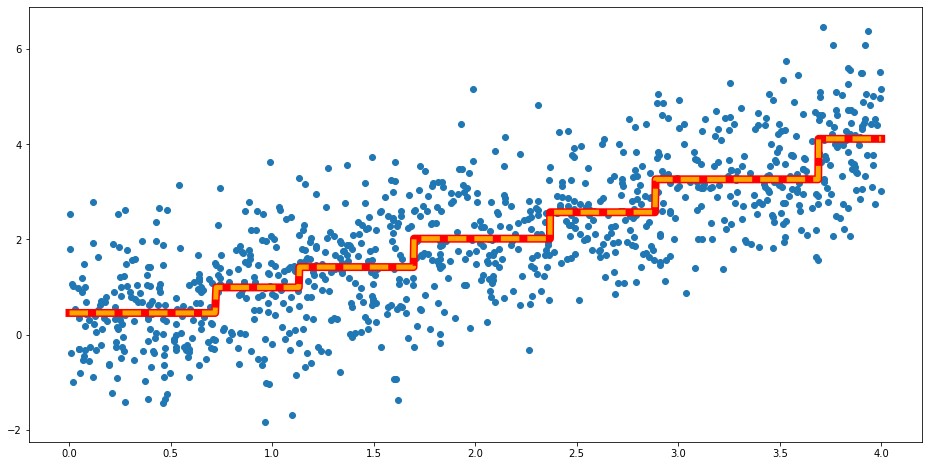

In [32]:
np.random.seed(0)
n = 1000
plt.rcParams["figure.figsize"] = (16,8)
X = np.random.uniform(size=(n,1),low=0,high=4)
y = np.random.normal(loc=X.ravel(),scale=1,size = n)
parameters = {'max_depth':[None, 5, 10],"min_samples_leaf": [1,5], "ccp_alpha" : [0,0.01]} # , 
clf = GridSearchCV(DecisionTreeRegressor(random_state=0), parameters).fit(X,y)
t = BaseLineTree(adaptive_complexity=True).fit(X,y)
params = clf.best_params_
plt.scatter(X,y)
plt.plot(np.sort(X,axis=0), t.predict(np.sort(X,axis=0)),c = "r", linewidth=8)
plt.plot(np.sort(X,axis=0), clf.predict(np.sort(X,axis=0)),c = "orange",linewidth=5,linestyle='dashed')


# MSE

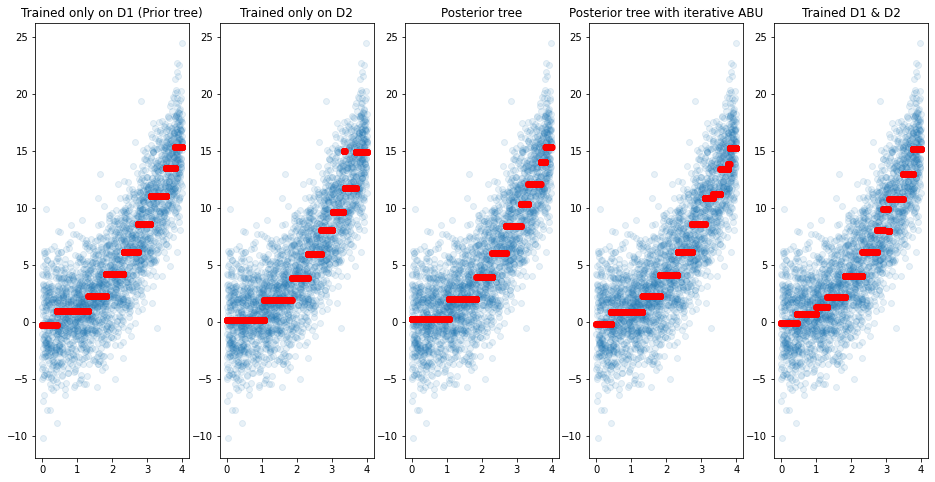

In [18]:
np.random.seed(0)
n = 2500
plt.rcParams["figure.figsize"] = (16,8)
X = np.random.uniform(size=(n,1),low=0,high=4)
y = np.random.normal(loc=X.ravel()**2,scale=3,size = n)
X1,X2,y1,y2 = train_test_split(X,y,test_size=0.25,random_state=0)

tree = AbuTree(adaptive_complexity=True,min_samples_leaf=5,criterion="mse").fit(X1,y1) # prior tree - only D1
tree2 = AbuTree(adaptive_complexity=True,min_samples_leaf=5,criterion="mse").fit(X2,y2) # only D2
tree3 = AbuTree(adaptive_complexity=True,min_samples_leaf=5,criterion="mse").fit(X,y) # D1 & D2
babu = BABUTree(adaptive_complexity=True,min_samples_leaf=5,criterion="mse",bumping_iterations=10).fit(X1,y1) # D1 & D2

# plot prior
plt.subplot(1,5,1)
ypred = tree.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)
plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title("Trained only on D1 (Prior tree)")

# plot only D2
plt.subplot(1,5,2)
ypred = tree2.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)
plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title("Trained only on D2")

# plot posterior
plt.subplot(1,5,3)
tree.update(X2,y2)
ypred = tree.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)
plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title(f"Posterior tree")

# plot plot posterior with iterative ABU
plt.subplot(1,5,4)
babu.update(X2,y2)
ypred = babu.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)

plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title("Posterior tree with iterative ABU")

# plot D1 & D2
plt.subplot(1,5,5)
ypred = tree3.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)

plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title("Trained D1 & D2")
plt.show()

## |D1| == |D2|

In [30]:
np.random.seed(0)
n = 1000 # data size
B = 1000 # number of simulations
loss_d1 = []
loss_d2 = []
loss_d12 = []
loss_abu = []

stability_base = []
stability_abu = []


X_test = np.random.uniform(size=(1000,1),low=0,high=4)
y_test = np.random.normal(loc=X_test.ravel(),scale=1,size = 1000)
for b in range(B):
    X = np.random.uniform(size=(n,1),low=0,high=4)
    y = np.random.normal(loc=X.ravel(),scale=1,size = n)
    X1,X2,y1,y2 = train_test_split(X,y,test_size=0.5,random_state=b)
    tree1 = AbuTree(criterion="mse", adaptive_complexity=True).fit(X1,y1) 
    tree2 = AbuTree(criterion="mse", adaptive_complexity=True).fit(X2,y2)
    tree3 = AbuTree(criterion="mse", adaptive_complexity=True).fit(X,y)
    tree4 = AbuTree(criterion="mse", adaptive_complexity=True).fit(X1,y1)
    tree4.update(X2,y2)
    stability_base.append(S2(tree1.predict(X_test),tree3.predict(X_test)))
    stability_abu.append(S2(tree1.predict(X_test),tree4.predict(X_test)))
    loss_d1.append(mean_squared_error(y_test,tree1.predict(X_test)))
    loss_d2.append(mean_squared_error(y_test,tree2.predict(X_test)))
    loss_d12.append(mean_squared_error(y_test,tree3.predict(X_test)))
    loss_abu.append(mean_squared_error(y_test,tree4.predict(X_test)))

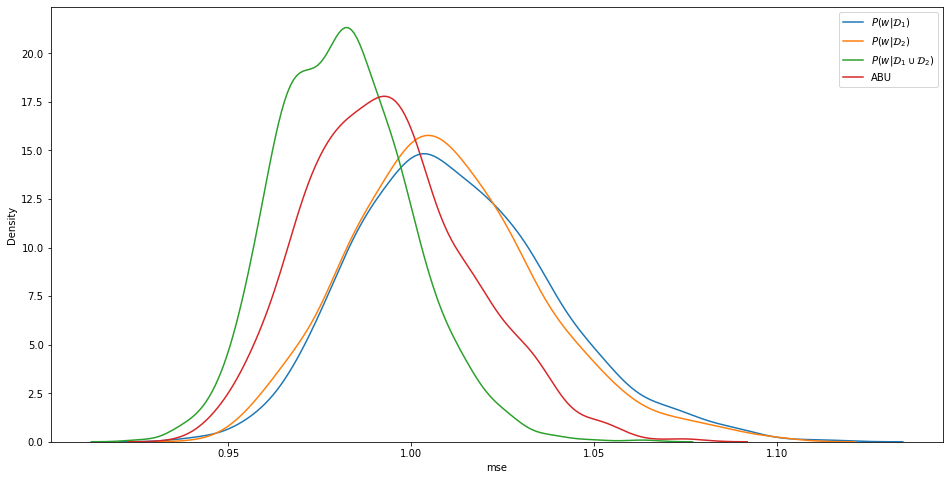

In [31]:
plt.rcParams["figure.figsize"] = (16,8)
sns.kdeplot(loss_d1,label=r'$P(w|\mathcal{D}_1)$')
sns.kdeplot(loss_d2,label=r'$P(w|\mathcal{D}_2)$')
sns.kdeplot(loss_d12,label=r'$P(w|\mathcal{D}_1 \cup \mathcal{D}_2)$')
sns.kdeplot(loss_abu,label='ABU')
plt.xlabel("mse",fontsize=10)
plt.legend()
plt.show()

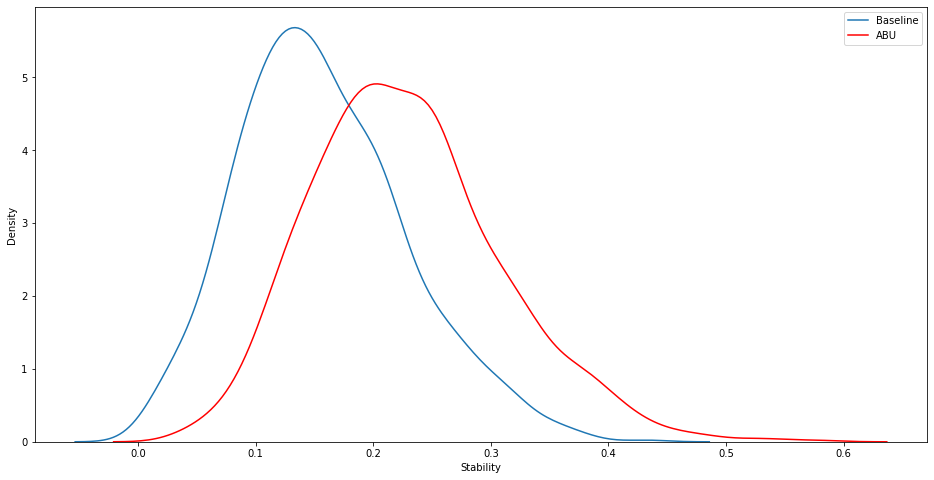

In [26]:
sns.kdeplot(stability_base,label='Baseline')
sns.kdeplot(stability_abu,label='ABU', c = "red")
plt.xlabel("Stability",fontsize=10)
plt.legend()
plt.show()

# Poisson

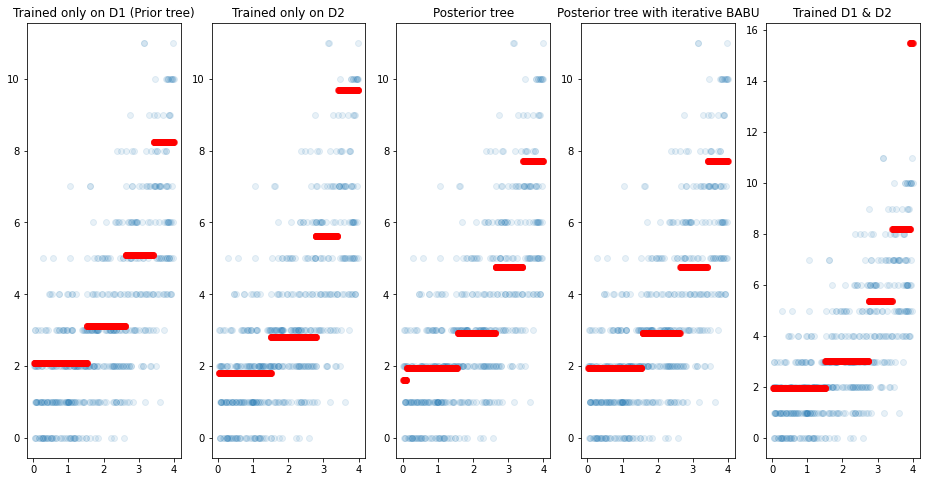

In [6]:
np.random.seed(0)
n = 500
plt.rcParams["figure.figsize"] = (16,8)
X = np.random.uniform(size=(n,1),low=0,high=4)
y = np.random.poisson(np.exp(0.5*X.ravel()),size=n) 
X1,X2,y1,y2 = train_test_split(X,y,test_size=0.5,random_state=0)

tree = AbuTreeI(adaptive_complexity=True,min_samples_leaf=5,criterion="poisson").fit(X1,y1) # prior tree - only D1
tree2 = AbuTreeI(adaptive_complexity=True,min_samples_leaf=5,criterion="poisson").fit(X2,y2) # only D2
tree3 = AbuTreeI(adaptive_complexity=True,min_samples_leaf=5,criterion="poisson").fit(X,y) # D1 & D2
babu = BABUTree(adaptive_complexity=True,min_samples_leaf=5,criterion="poisson").fit(X1,y1) # D1 & D2

# plot prior
plt.subplot(1,5,1)
ypred = tree.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)
plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title("Trained only on D1 (Prior tree)")

# plot only D2
plt.subplot(1,5,2)
ypred = tree2.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)
plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title("Trained only on D2")

# plot posterior
plt.subplot(1,5,3)
tree.update(X2,y2)
ypred = tree.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)
plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title(f"Posterior tree")

# plot plot posterior with iterative ABU
plt.subplot(1,5,4)
babu.update(X2,y2)
ypred = babu.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)

plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title("Posterior tree with iterative BABU")

# plot D1 & D2
plt.subplot(1,5,5)
ypred = tree3.predict(X)
plt.scatter(X[:,0],y, alpha = 0.1)

plt.scatter(X[:,0],ypred[:],c ="red", alpha = 0.5)
plt.title("Trained D1 & D2")
plt.show()

## |D1| ==|D2|

In [ ]:
np.random.seed(0)
n = 2000 # data size
B = 1000 # number of simulations
loss_d1 = []
loss_d2 = []
loss_d12 = []
loss_abu = []


stability_base = []
stability_abu = []


for b in range(B):
    X = np.random.uniform(size=(n,1),low=0,high=4)
    y = np.random.poisson(X.ravel(),size=n)  + EPSILON
    X1,X2,y1,y2 = train_test_split(X,y,test_size=0.5,random_state=b)
    tree1 = AbuTreeI(criterion="poisson", adaptive_complexity=True).fit(X1,y1)
    tree2 = AbuTreeI(criterion="poisson", adaptive_complexity=True).fit(X2,y2)
    tree3 = AbuTreeI(criterion="poisson", adaptive_complexity=True).fit(X,y)
    tree4 = AbuTreeI(criterion="poisson", adaptive_complexity=True).fit(X1,y1)
    tree4.update(X2,y2)
    
    stability_base.append(S1(tree1.predict(X),tree2.predict(X)))
    stability_abu.append(S1(tree1.predict(X),tree4.predict(X)))

    loss_d1.append(mean_poisson_deviance(y,tree1.predict(X)))
    loss_d2.append(mean_poisson_deviance(y,tree2.predict(X)))
    loss_d12.append(mean_poisson_deviance(y,tree3.predict(X)))
    loss_abu.append(mean_poisson_deviance(y,tree4.predict(X)))

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)
sns.kdeplot(loss_d1,label='d1')
sns.kdeplot(loss_d2,label='d2')
sns.kdeplot(loss_d12,label='d1 & d2')
sns.kdeplot(loss_abu,label='abu')
plt.legend()
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)
sns.kdeplot(stability_base,label='base')
sns.kdeplot(stability_abu,label='abu', c = "red")
plt.legend()
plt.show()